In [167]:
import re

import pandas as pd
import os
import zipfile

# Path to the zip file
zip_path = './Grocery_Data.zip'
# Temporary directory to extract files
extract_dir = './Grocery_Data'

# Ensure the extract directory exists
os.makedirs(extract_dir, exist_ok=True)

# Extracting the data

In [168]:
epicerie_products = None
epicerie_metadata = None
# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_dir)

    # Assuming you know the name of the file you want to read, or there's only one file
    # You could also iterate over all files if needed
    file_names = zip_ref.namelist()
    for file_name in file_names:
        full_file_path = os.path.join(extract_dir, file_name)
        # Construct the full path to the extracted file
        if ((file_name == 'products_raw_data.csv') == 1) or ((file_name == 'products_data.csv')):
            if (file_name == 'products_raw_data.csv') == 1:
                epicerie_metadata = pd.read_csv(full_file_path, sep=',')

            if (file_name == 'products_data.csv') == 1:
                epicerie_products = pd.read_csv(full_file_path, sep=',')

In [169]:
epicerie_products.head()

,Name,Current Price,Previous Price,Price Per Each,Category,Product ID,Product URL,Amount,Units
0,English Cucumber,1.99,1.99,$1.99/1ea,Fresh Vegetables,20070132001_EA,https://www.realcanadiansuperstore.ca/english-...,1,ea
1,Green Onion,1.29,1.29,$1.29/1ea,Fresh Vegetables,20107500001_EA,https://www.realcanadiansuperstore.ca/green-on...,1,bunch
2,"Bi-Colour Corn, Corn on the Cob",0.99,0.99,$0.99/1ea,Fresh Vegetables,20131170001_EA,https://www.realcanadiansuperstore.ca/bi-colou...,1,ea
3,"Romaine Heart, 3 Pack",6.00,6.00,$2.00/1ea,Fresh Vegetables,20067389001_EA,https://www.realcanadiansuperstore.ca/romaine-...,3,pack
4,Red Peppers,2.38,2.38,$9.90/1kg,Fresh Vegetables,20007535001_KG,https://www.realcanadiansuperstore.ca/red-pepp...,1,ea


# Data Preparation

## Typing the columns

In [170]:
epicerie_products.dtypes

Name              object
Current Price     object
Previous Price    object
Price Per Each    object
Category          object
Product ID        object
Product URL       object
Amount            object
Units             object
dtype: object

In [187]:
# using re to findall non numeric characters in the column and replacing them with empty string
epicerie_products['Amount'] = epicerie_products['Amount'].apply(lambda x: re.sub('[^0-9]', '', x)[0]).apply(lambda x: float(x.replace(' ', '').replace(',', '')))

In [190]:
epicerie_products_dtypes = {'Name': 'string', 'Current Price': 'float64', 'Previous Price': 'float64', 'Price Per Each':'string', 'Category':'string','Product ID':'string','Product URL':'string', 'Amount': 'int32', 'Units': 'string'}

In [191]:
epicerie_products = epicerie_products.astype(epicerie_products_dtypes)

In [192]:
epicerie_products.dtypes

Name               string
Current Price     float64
Previous Price    float64
Price Per Each     string
Category           string
Product ID         string
Product URL        string
Amount              int32
Units              string
dtype: object

##  Feature Engineering the Price Per Each Column to add a new column 'unit_price', to complement the Units feature already present and make the price comparable when deciding the price of a product individually versus when bundled for cost analysis

In [163]:
epicerie_products.loc[:, ['Units', 'Price Per Each']].head()

,Units,Price Per Each
0,ea,$1.99/1ea
1,bunch,$1.29/1ea
2,ea,$0.99/1ea
3,pack,$2.00/1ea
4,ea,$9.90/1kg


In [196]:
epicerie_products['unit_price'] = epicerie_products['Price Per Each'].apply(lambda x: re.findall('[0-9]+', x)[0])

In [197]:
epicerie_products['unit_price'] = epicerie_products['unit_price'].astype('float')

In [198]:
epicerie_products.head()

,Name,Current Price,Previous Price,Price Per Each,Category,Product ID,Product URL,Amount,Units,unit_price
0,English Cucumber,1.99,1.99,$1.99/1ea,Fresh Vegetables,20070132001_EA,https://www.realcanadiansuperstore.ca/english-...,1,ea,1.0
1,Green Onion,1.29,1.29,$1.29/1ea,Fresh Vegetables,20107500001_EA,https://www.realcanadiansuperstore.ca/green-on...,1,bunch,1.0
2,"Bi-Colour Corn, Corn on the Cob",0.99,0.99,$0.99/1ea,Fresh Vegetables,20131170001_EA,https://www.realcanadiansuperstore.ca/bi-colou...,1,ea,0.0
3,"Romaine Heart, 3 Pack",6.00,6.00,$2.00/1ea,Fresh Vegetables,20067389001_EA,https://www.realcanadiansuperstore.ca/romaine-...,3,pack,2.0
4,Red Peppers,2.38,2.38,$9.90/1kg,Fresh Vegetables,20007535001_KG,https://www.realcanadiansuperstore.ca/red-pepp...,1,ea,9.0


In [200]:
epicerie_products.dtypes

Name               string
Current Price     float64
Previous Price    float64
Price Per Each     string
Category           string
Product ID         string
Product URL        string
Amount              int32
Units              string
unit_price        float64
dtype: object

# Exploratory Data Analysis

In [210]:
# selecting all the numeric float64 columns
numerical_columns = epicerie_products.select_dtypes(include=['float64'])

In [216]:
# adding the columns necessary for our analysis ('Unit' and 'Name')
analyse_batch_price = pd.concat([epicerie_products.loc[:, ['Name', 'Units']].copy(deep=True), numerical_columns], axis=1)

<AxesSubplot:>

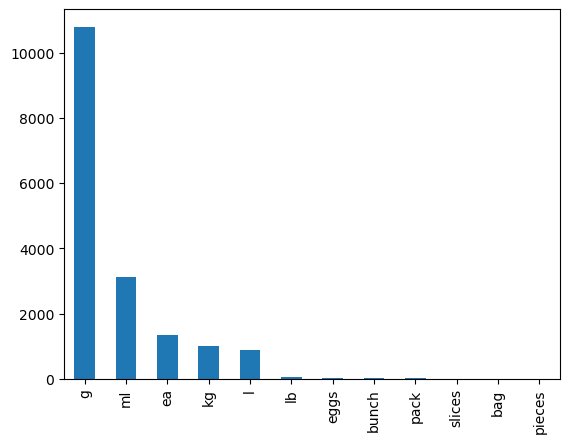

In [219]:
# exploring batch types by making a barchar of Units frequency
analyse_batch_price['Units'].value_counts().plot(kind='bar')

In [220]:
# Exploring the names of the most popular units used
analyse_batch_price['Units'].value_counts()

g         10792
ml         3132
ea         1352
kg         1002
l           876
lb           44
eggs         21
bunch        20
pack         16
slices        2
bag           1
pieces        1
Name: Units, dtype: Int64

<AxesSubplot:xlabel='Units'>

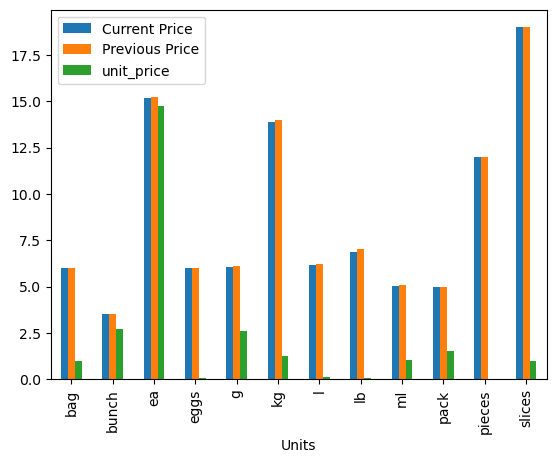

In [229]:
analyse_batch_price.groupby('Units').mean().plot(kind='bar')

# Conclusion
The unit price of each implies that the product name is indivisable. For example, 'each apple' would imply the unit is the same price as the current price (or we would suppose given common sense). This chart shows that the unit price of each is almost consistently the same as the current price which would fit my naive understanding. We notice quickly that almost all of the Units' features categories have unit_prices that are lower than the Current Price or Previous Price. This implies that the unit price is lower than the price of the product when bought in bulk. This is a good sanity check to ensure that the data and our understanding of the unit types is correct.